# Task 3 – Signal Preprocessing (Hand Activity Recognition)

This notebook implements **Task 3: Signal Preprocessing** for the Hand Activity Recognition project using the raw WISDM `.txt` file.

Goals:
- Load the raw WISDM accelerometer data from a `.txt` file
- Handle missing data via interpolation and filling
- Apply a 4th-order Butterworth low-pass filter (noise reduction)
- Produce **before vs. after** plots of the signals
- Provide short narrative text that can be copied into the project report


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import os

# === Path to your raw WISDM TXT file ===
# Update RAW_DIR and FILENAME if needed
RAW_DIR = 'wisdm-dataset/raw/phone/accel'  # folder containing data_XXXX_accel_phone.txt
FILENAME = 'data_1647_accel_phone.txt'     # example subject file

path = os.path.join(RAW_DIR, FILENAME)
print('Loading from:', path)

# WISDM raw format: Subject-id, Activity, Timestamp, x, y, z;
df = pd.read_csv(
    path,
    header=None,
    names=['Subject-id', 'Activity', 'Timestamp', 'X-accel', 'Y-accel', 'Z-accel'],
    sep=',',
)

# Clean Z-accel (remove trailing semicolon) and convert to float
df['Z-accel'] = df['Z-accel'].astype(str).str.replace(';', '', regex=False)
df['Z-accel'] = pd.to_numeric(df['Z-accel'], errors='coerce')

# Ensure X-accel and Y-accel are numeric
df['X-accel'] = pd.to_numeric(df['X-accel'], errors='coerce')
df['Y-accel'] = pd.to_numeric(df['Y-accel'], errors='coerce')

print('Shape:', df.shape)
df.head()

Loading from: wisdm-dataset/raw/phone/accel\data_1647_accel_phone.txt
Shape: (81887, 6)


,Subject-id,Activity,Timestamp,X-accel,Y-accel,Z-accel
0,1647,A,1218321040520142,-0.030526,5.834071,6.162675
1,1647,A,1218321080855818,0.356137,4.556166,9.785701
2,1647,A,1218321121708318,1.125873,4.935647,8.513183
3,1647,A,1218321161310247,0.203507,6.432621,7.170634
4,1647,A,1218321202732172,0.345962,7.040150,7.488464


In [2]:
# Basic info and missing values check
print(df.info())
print('\nMissing values per column:')
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81887 entries, 0 to 81886
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject-id  81887 non-null  int64  
 1   Activity    81887 non-null  object 
 2   Timestamp   81887 non-null  int64  
 3   X-accel     81887 non-null  float64
 4   Y-accel     81887 non-null  float64
 5   Z-accel     81887 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 3.7+ MB
None

Missing values per column:
Subject-id    0
Activity      0
Timestamp     0
X-accel       0
Y-accel       0
Z-accel       0
dtype: int64


In [3]:
numeric_cols = ['X-accel', 'Y-accel', 'Z-accel']

# Linear interpolation for missing sensor values
df[numeric_cols] = df[numeric_cols].interpolate(method='linear')

# If NaNs remain at the beginning or end, forward/backward fill
df[numeric_cols] = df[numeric_cols].fillna(method='bfill').fillna(method='ffill')

print('Missing values after interpolation/fill:')
print(df[numeric_cols].isna().sum())

Missing values after interpolation/fill:
X-accel    0
Y-accel    0
Z-accel    0
dtype: int64


C:\Users\nghia\AppData\Local\Temp\ipykernel_32776\3417234408.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[numeric_cols] = df[numeric_cols].fillna(method='bfill').fillna(method='ffill')


In [4]:
# Butterworth low-pass filter parameters
# WISDM dataset was collected at ~20 Hz (20 samples/second)
fs = 20              # sampling frequency (Hz)
cutoff = 5           # cutoff frequency (Hz)
order = 4            # 4th-order Butterworth

nyq = fs / 2.0
b, a = butter(order, cutoff / nyq, btype='low')

# Apply filtfilt for zero-phase filtering on each axis
for col in numeric_cols:
    df[col + '_filt'] = filtfilt(b, a, df[col].values)

df[[c for c in df.columns if 'filt' in c]].head()

,X-accel_filt,Y-accel_filt,Z-accel_filt
0,-0.030398,5.834134,6.161923
1,0.614135,4.748323,8.696774
2,0.600825,5.102694,8.861103
3,0.457594,6.180042,7.827805
4,0.854924,6.555140,7.566224


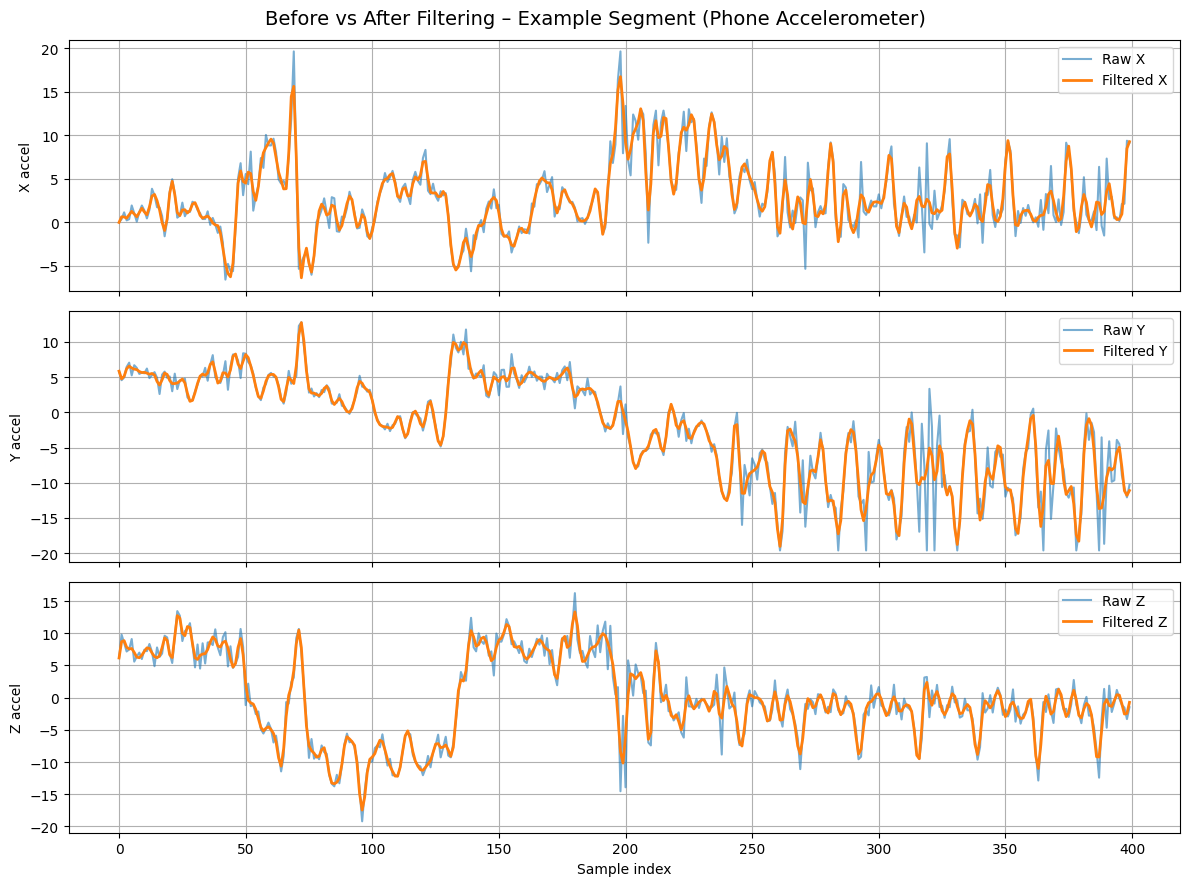

In [5]:
# Plot a sample segment: raw vs filtered for each axis

# Choose a segment (first 400 samples of the file)
segment = df.iloc[:400]

fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

axes[0].plot(segment['X-accel'], label='Raw X', alpha=0.6)
axes[0].plot(segment['X-accel_filt'], label='Filtered X', linewidth=2)
axes[0].set_ylabel('X accel')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(segment['Y-accel'], label='Raw Y', alpha=0.6)
axes[1].plot(segment['Y-accel_filt'], label='Filtered Y', linewidth=2)
axes[1].set_ylabel('Y accel')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(segment['Z-accel'], label='Raw Z', alpha=0.6)
axes[2].plot(segment['Z-accel_filt'], label='Filtered Z', linewidth=2)
axes[2].set_ylabel('Z accel')
axes[2].set_xlabel('Sample index')
axes[2].legend()
axes[2].grid(True)

fig.suptitle('Before vs After Filtering – Example Segment (Phone Accelerometer)', fontsize=14)
plt.tight_layout()
plt.show()

# Optional: save the figure for the report
# fig.savefig('task3_before_after_filtering.png', dpi=300, bbox_inches='tight')

## Narrative for Report (Task 3 – Signal Preprocessing)

Signal preprocessing is necessary because the raw accelerometer data contains sensor noise, high-frequency jitter, and occasional missing samples. We first applied linear interpolation to the X, Y, and Z accelerometer channels, followed by backward and forward filling when needed, to obtain a continuous time series without missing values.

To remove high-frequency noise while preserving meaningful motion patterns, we used a 4th-order Butterworth low-pass filter with a 5 Hz cutoff, based on the 20 Hz sampling rate of the WISDM dataset. The Butterworth design provides a maximally flat passband and, when applied with zero-phase filtering (`filtfilt`), avoids phase distortion that would otherwise shift or deform the activity waveforms.

The before-and-after plots show that the filtered signals are smoother and less noisy while retaining the overall amplitude and shape of the original motion trajectories. This preprocessing step improves the signal-to-noise ratio and prepares the data for subsequent windowing, feature extraction, and classification.
